In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# 确保支持中文绘图
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

# 导入自定义模块
# 假设当前目录已经是 d:\degree_code\scheme_1_PID
try:
    from pid import MultiLoopPID, PIDController
    from greenhouse_env import VirtualGreenhouse
    from issa import ISSAOptimizer
except ImportError:
    # 如果直接运行notebook找不到模块，添加当前路径到sys.path
    sys.path.append(os.getcwd())
    from pid import MultiLoopPID, PIDController
    from greenhouse_env import VirtualGreenhouse
    from issa import ISSAOptimizer

## 2. 定义适应度函数与滚动优化逻辑

### TPLC-Net 在此模块中的作用
在完整的 Scheme 1 系统中，模块四利用 **TPLC-Net (已训练好的模型)** 作为**系统预测模型 (System Model)**。
*   **输入**: 历史环境序列 + 优化器生成的**未来控制序列** ($u_{t}, ..., u_{t+H}$).
    *   **关键特征**: Tair, Rhair, CO2air (自回归), VentLee, Ventwind (通风), PipeGrow, PipeLow (加热), AssimLight, co2_dos, EnScr, BlackScr (控制), Tot_PAR (光照扰动).
*   **输出**: 预测的**未来环境状态** ($\hat{T}_{t+1:t+H}, \hat{Rh}_{t+1:t+H}, \hat{CO2}_{t+1:t+H}$).
*   **作用**: 它充当了适应度函数中的**模拟器**，告诉 ISSA 算法“如果你使用这组 PID 参数，未来的温度/湿度会变成什么样”。

> **注意**: 为了保证本 Demo 的独立可运行性，我们下方的 `rolling_optimization` 函数中使用了一个**简化的物理公式**来代替 TPLC-Net 进行预测。在实际部署时，应将物理公式替换为 TPLC-Net 的推理接口 (Inference)。

适应度函数 $J$ 用于评估一组 PID 参数的优劣。计算公式为：
$$ J = \sum_{h=1}^{H} \left[ \omega_{T} ( \hat{T}_{t+h} - T_{opt} )^2 + \omega_{Rh} ( \hat{Rh}_{t+h} - Rh_{opt} )^2 \right] $$

In [2]:
def rolling_optimization(env_model, current_state, target_temp, target_rh, horizon=5):
    """
    滚动优化核心函数
    Args:
        env_model: 虚拟温室模型 (具备 step 和 reset 功能)
        current_state: 当前 [temp, rh]
        target_temp: 目标温度序列 (或者是单个固定值)
        target_rh: 目标湿度序列
        horizon: 预测步长 H
        
    Returns:
        best_params: 最优PID参数 [kp_t, ki_t, kd_t, kp_h, ki_h, kd_h]
    """
    
    # 1. 定义适应度函数 (闭包，捕获当前上下文)
    def fitness_function(params):
        """
        评估一组参数 params 的损失
        params: [Kp_t, Ki_t, Kd_t, Kp_h, Ki_h, Kd_h]
        """
        # 初始化临时 PID 控制器
        temp_pid = PIDController(params[0], params[1], params[2], output_limits=(-100, 100))
        hum_pid = PIDController(params[3], params[4], params[5], output_limits=(-100, 100))
        
        # 初始化临时环境副本用于预测 (重置到当前真实状态)
        curr_t, curr_r = current_state
        sim_step = env_model.time_step # 保持时间同步以获取准确的外部天气
        
        # 并不真的重置环境对象，而是我们用简单的物理公式手动推演未来 H 步
        # 或者使用 env_model 提供的一个 predict 方法，这里为了通用，我们假设 env_model 有 predict 接口
        # 但为了演示简单，我们直接复用 env_model.predict_future 接口
        
        loss = 0.0
        
        # 模拟未来 H 步
        # 注意：由于 PID 是闭环的，控制量 u 取决于状态 x，状态 x 又取决于 u
        # 所以需要逐步迭代
        
        sim_temp = curr_t
        sim_rh = curr_r
        
        # 临时模型的系数 (这应该与 greenhouse_env 中一致)
        alpha_t, beta_t = 0.05, 0.02
        alpha_h, beta_h = 0.03, 0.015
        
        for h in range(horizon):
            # 1. 计算控制量
            tgt_t = target_temp[h] if isinstance(target_temp, list) else target_temp
            tgt_r = target_rh[h] if isinstance(target_rh, list) else target_rh
            
            u_t = temp_pid.update(tgt_t, sim_temp)
            u_r = hum_pid.update(tgt_r, sim_rh)
            
            # 2. 预测下一步状态 (使用简化的确定性模型，不加噪声)
            # 获取外部天气预报 (这里调用模型获取真值作为预报)
            ext_temp, ext_rh = env_model.get_external_weather(sim_step + h)
            
            # 物理演化
            d_t = alpha_t * (ext_temp - sim_temp) + beta_t * u_t
            d_r = alpha_h * (ext_rh - sim_rh) + beta_h * u_r
            
            sim_temp += d_t
            sim_rh += d_r
            
            # 3. 累加损失
            w_t, w_r = 1.0, 0.5 # 权重
            loss += w_t * (sim_temp - tgt_t)**2 + w_r * (sim_rh - tgt_r)**2
            
        return loss

    # 2. 运行 ISSA 优化
    # 针对 PID 参数，范围设为 0~20
    optimizer = ISSAOptimizer(pop_size=10, dim=6, max_iter=20, lb=0, ub=20)
    best_params, history = optimizer.optimize(fitness_function)
    
    return best_params, history

## 3. 运行主仿真实验

我们将模拟一天 (24小时) 的控制过程。每小时进行一次参数优化 (简化为了演示速度)。真实的控制频率可能更高 (如每分钟)。

In [3]:
# 初始化环境
env = VirtualGreenhouse()
current_state = env.reset(init_temp=20, init_rh=50)

# 设定目标值 (例如：白天 25度/60%，晚上 18度/80%)
def get_target(t):
    # 简单的日夜切换
    day_time = (t % 1440) 
    if 360 < day_time < 1080: # 6:00 - 18:00
        return 26.0, 60.0
    else:
        return 18.0, 80.0

# 记录数据
history_temp = []
history_rh = []
history_target_temp = []
history_target_rh = []
history_u_temp = []
history_u_rh = []
history_params = []

# 初始化一个PID控制器 (用于实际控制)
real_controller = MultiLoopPID([1,0,0], [1,0,0]) 

# 仿真步数 (模拟 200 个时间步)
steps = 200

print("开始仿真...")
for t in range(steps):
    curr_temp, curr_rh = current_state
    tgt_temp, tgt_rh = get_target(env.time_step)
    
    # === 关键步骤：滚动优化 PID 参数 ===
    # 为了演示效率，并非每一步都优化，可以设定频率 (例如每 10 步优化一次)
    if t % 10 == 0:
        # print(f"Step {t}: Optimizing...")
        # 预测时域 H=10
        future_targets_t = [get_target(env.time_step + h)[0] for h in range(10)]
        future_targets_r = [get_target(env.time_step + h)[1] for h in range(10)]
        
        best_params, _ = rolling_optimization(
            env, 
            [curr_temp, curr_rh], 
            future_targets_t, 
            future_targets_r, 
            horizon=10
        )
        # 更新控制器参数
        real_controller.set_parameters(best_params)
        
    history_params.append(best_params)
        
    # === 执行控制 ===
    u_t, u_r = real_controller.step(tgt_temp, curr_temp, tgt_rh, curr_rh)
    
    # 环境演化
    current_state = env.step(u_t, u_r)
    
    # 记录
    history_temp.append(curr_temp)
    history_rh.append(curr_rh)
    history_target_temp.append(tgt_temp)
    history_target_rh.append(tgt_rh)
    history_u_temp.append(u_t)
    history_u_rh.append(u_r)

print("仿真结束")

开始仿真...
仿真结束


## 4. 结果可视化
绘制温度和湿度的跟踪曲线，以及PID参数的变化情况。

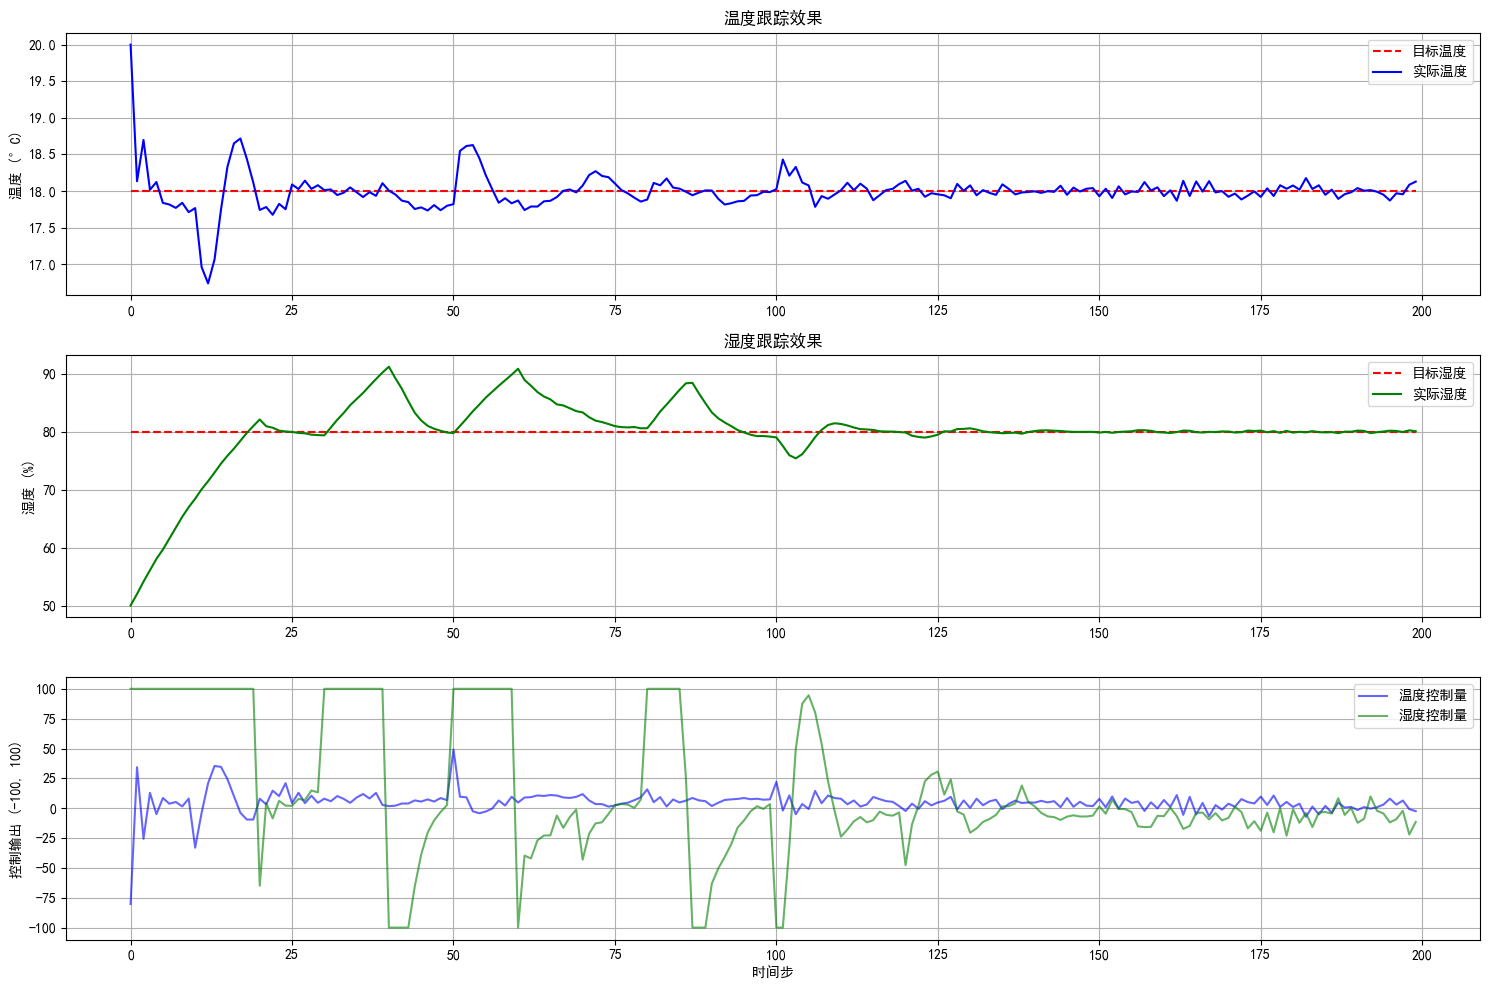

In [4]:
plt.figure(figsize=(15, 10))

# 1. 温度控制效果
plt.subplot(3, 1, 1)
plt.plot(history_target_temp, 'r--', label='目标温度')
plt.plot(history_temp, 'b-', label='实际温度')
plt.ylabel('温度 (°C)')
plt.title('温度跟踪效果')
plt.legend()
plt.grid(True)

# 2. 湿度控制效果
plt.subplot(3, 1, 2)
plt.plot(history_target_rh, 'r--', label='目标湿度')
plt.plot(history_rh, 'g-', label='实际湿度')
plt.ylabel('湿度 (%)')
plt.title('湿度跟踪效果')
plt.legend()
plt.grid(True)

# 3. 控制输入
plt.subplot(3, 1, 3)
plt.plot(history_u_temp, 'b-', alpha=0.6, label='温度控制量')
plt.plot(history_u_rh, 'g-', alpha=0.6, label='湿度控制量')
plt.ylabel('控制输出 (-100, 100)')
plt.xlabel('时间步')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

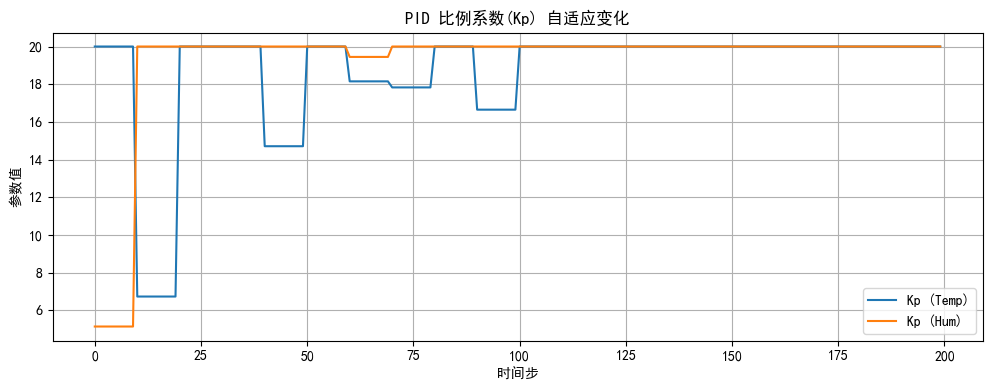

In [5]:
# 可视化 PID 参数自适应过程 (以温度Kp为例)
params_arr = np.array(history_params)
plt.figure(figsize=(12, 4))
plt.plot(params_arr[:, 0], label='Kp (Temp)')
plt.plot(params_arr[:, 3], label='Kp (Hum)')
plt.title("PID 比例系数(Kp) 自适应变化")
plt.xlabel("时间步")
plt.ylabel("参数值")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# === 5. 定量评估报告 ===
# 计算误差指标
temp_error = np.array(history_temp) - np.array(history_target_temp)
rh_error = np.array(history_rh) - np.array(history_target_rh)

rmse_temp = np.sqrt(np.mean(temp_error**2))
rmse_rh = np.sqrt(np.mean(rh_error**2))

mae_temp = np.mean(np.abs(temp_error))
mae_rh = np.mean(np.abs(rh_error))

print(f"=== 控制效果定量评估 (Steps: {steps}) ===")
print(f"温度指标:")
print(f"  RMSE: {rmse_temp:.4f} °C")
print(f"  MAE:  {mae_temp:.4f} °C")
print(f"  Max Error: {np.max(np.abs(temp_error)):.4f} °C")
print("-" * 30)
print(f"湿度指标:")
print(f"  RMSE: {rmse_rh:.4f} %")
print(f"  MAE:  {mae_rh:.4f} %")
print(f"  Max Error: {np.max(np.abs(rh_error)):.4f} %")
print("-" * 30)

# 评估控制平稳性 (计算控制量的标准差)
std_u_t = np.std(history_u_temp)
std_u_r = np.std(history_u_rh)
print(f"控制平稳性 (输出标准差):")
print(f"  U_Temp Std: {std_u_t:.4f}")
print(f"  U_RH Std:   {std_u_r:.4f}")

=== 控制效果定量评估 (Steps: 200) ===
温度指标:
  RMSE: 0.2580 °C
  MAE:  0.1369 °C
  Max Error: 2.0000 °C
------------------------------
湿度指标:
  RMSE: 5.9971 %
  MAE:  2.9783 %
  Max Error: 30.0000 %
------------------------------
控制平稳性 (输出标准差):
  U_Temp Std: 9.9020
  U_RH Std:   54.4275
